In [841]:
import numpy as np                                                 # Implemennts milti-dimensional array and matrices
import pandas as pd                                                # For data manipulation and analysis
import pandas_profiling
import matplotlib.pyplot as plt                                    # Plotting library for Python programming language and it's numerical mathematics extension NumPy
import seaborn as sns                                              # Provides a high level interface for drawing attractive and informative statistical graphics
%matplotlib inline
sns.set()

from subprocess import check_output
from collections import Counter
import os

In [ ]:
# Uncomment on kaggle to know data path
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [713]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [714]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [715]:
test_PassengerId = test["PassengerId"]

# Outlier treatment

In [716]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  

In [717]:
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [718]:
train[["Age","SibSp","Parch","Fare"]].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [719]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [720]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# joining train and test

In [721]:
print(train.shape)
print(test.shape)

(881, 12)
(418, 11)


In [722]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# Missing Values and NA treatment

In [723]:
# dataset = dataset.fillna(np.nan)

In [724]:
miss = dataset.isna().sum().sort_values().reset_index()
miss.columns = ['column', 'total_miss']
percent = (dataset.isna().sum()/dataset.shape[0])*100
percent = percent.sort_values().reset_index()
percent.columns = ['column', 'percent_miss']
miss = pd.merge(left=miss, right=percent, on='column')
miss.sort_values(by='percent_miss', ascending=False)

,column,total_miss,percent_miss
11,Cabin,1007,77.521170
10,Survived,418,32.178599
9,Age,256,19.707467
8,Embarked,2,0.153965
7,Fare,1,0.076982
0,Name,0,0.000000
1,Parch,0,0.000000
2,PassengerId,0,0.000000
3,Pclass,0,0.000000
4,Sex,0,0.000000


In [725]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [726]:
dataset["Embarked"] = dataset["Embarked"].fillna(dataset['Embarked'].mode()[0])


In [727]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med


# Feature Engineering

In [728]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1

In [729]:
dataset['GenderClass'] = dataset.apply(lambda x: 'child' if x['Age'] < 15 else x['Sex'],axis=1)

In [730]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [731]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [732]:
dataset = pd.get_dummies(dataset, columns=['GenderClass','Embarked'])

In [733]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [734]:
# dataset["Cabin"][dataset["Cabin"].notnull()].head()

In [735]:
# dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [736]:
# dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [737]:
# Ticket = []
# for i in list(dataset.Ticket):
#     if not i.isdigit() :
#         Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
#     else:
#         Ticket.append("X")
        
# dataset["Ticket"] = Ticket
# dataset["Ticket"].head()

In [738]:
# dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [739]:
dataset = dataset.drop(['Name','Sex','SibSp','Parch', 'PassengerId', 'Cabin','Ticket'], axis = 1)


In [740]:
dataset.head(5)

,Age,Fare,Survived,FamilySize,Title,GenderClass_child,GenderClass_female,GenderClass_male,Embarked_C,Embarked_Q,Embarked_S,Pc_1,Pc_2,Pc_3
0,22.0,7.2500,0.0,2,2,0,0,1,0,0,1,0,0,1
1,38.0,71.2833,1.0,2,1,0,1,0,1,0,0,1,0,0
2,26.0,7.9250,1.0,1,1,0,1,0,0,0,1,0,0,1
3,35.0,53.1000,1.0,2,1,0,1,0,0,0,1,1,0,0
4,35.0,8.0500,0.0,1,2,0,0,1,0,0,1,0,0,1


In [741]:
train = dataset.iloc[:train_len]
test = dataset.iloc[train_len:]
test.drop(['Survived'], axis=1, inplace=True)

In [742]:
train.Survived = train.Survived.astype('int64')

In [743]:
print(train.shape)
print(test.shape)

(881, 14)
(418, 13)


Text(0.5, 1, 'Pair Plot')

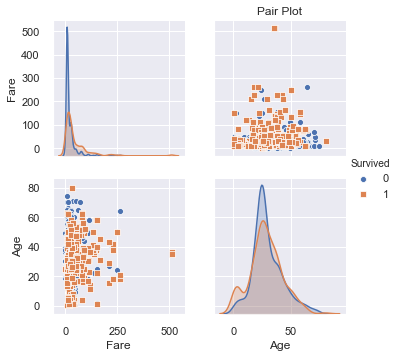

In [744]:
sns.pairplot(train[["Fare","Age","Survived"]],vars = ["Fare","Age"],hue="Survived", dropna=True,markers=["o", "s"])
plt.title('Pair Plot')

In [745]:
corr = train.corr()[['Age', 'Fare', 'FamilySize', 'Title', 'GenderClass_female', 'Embarked_Q', 'Pc_1', 'Survived']]

<Figure size 720x720 with 0 Axes>

Text(0.5, 1, 'Correlation between features')

(10, 0)

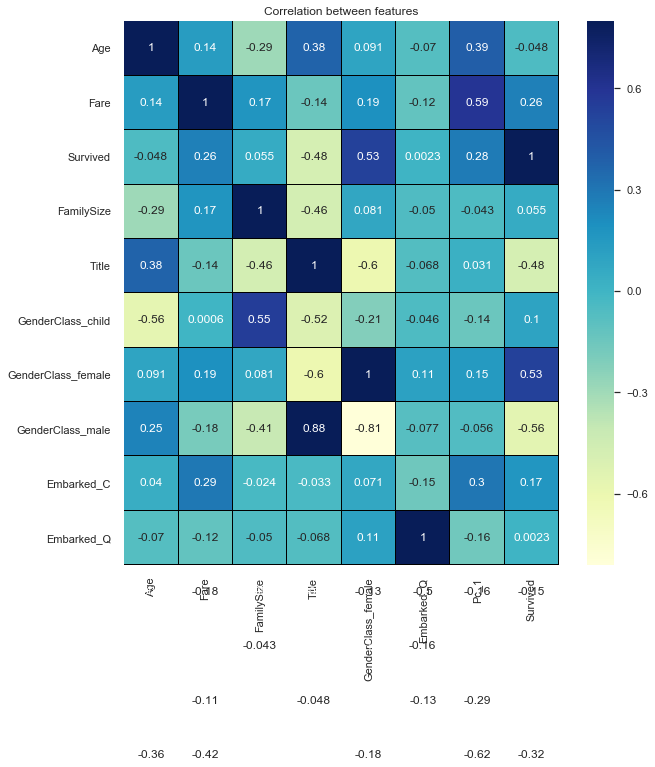

In [746]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')
plt.ylim(10, 0)

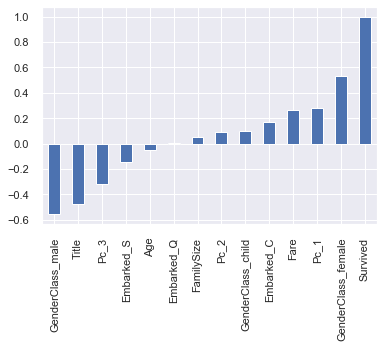

In [747]:
corr['Survived'].sort_values().plot(kind='bar')

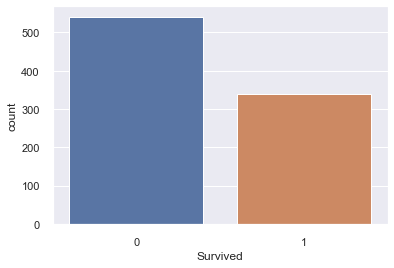

In [767]:
sns.countplot(x='Survived',data=train)

# Modeling

In [831]:
X = train.loc[:,train.columns != 'Survived']
X.head()

,Age,Fare,FamilySize,Title,GenderClass_child,GenderClass_female,GenderClass_male,Embarked_C,Embarked_Q,Embarked_S,Pc_1,Pc_2,Pc_3
0,22.0,7.2500,2,2,0,0,1,0,0,1,0,0,1
1,38.0,71.2833,2,1,0,1,0,1,0,0,1,0,0
2,26.0,7.9250,1,1,0,1,0,0,0,1,0,0,1
3,35.0,53.1000,2,1,0,1,0,0,0,1,1,0,0
4,35.0,8.0500,1,2,0,0,1,0,0,1,0,0,1


In [832]:
y = train.Survived 

In [833]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [834]:
print(X_train.shape)
print(y_train.shape)

(792, 13)
(792,)


In [840]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [824]:
y_pred_train = logreg.predict(X_train)  

In [825]:
y_pred_test = logreg.predict(X_test)                                                           # make predictions on the testing set

# Model Evaluation

In [826]:
from sklearn.metrics import accuracy_score
print('Accuracy score for test data is:', accuracy_score(y_test,y_pred_test))

Accuracy score for test data is: 0.8314606741573034


In [827]:
from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test))

print(confusion_matrix)

    0   1
0  48   7
1   8  26


In [828]:
confusion_matrix.index = ['Actual Died','Actual Survived']
confusion_matrix.columns = ['Predicted Died','Predicted Survived']
print(confusion_matrix)

                 Predicted Died  Predicted Survived
Actual Died                  48                   7
Actual Survived               8                  26


In [829]:
preds1 = np.where(logreg.predict_proba(X_test)[:,1]> 0.75,1,0)
print('Accuracy score for test data is:', accuracy_score(y_test,preds1))

Accuracy score for test data is: 0.7752808988764045


In [830]:
preds2 = np.where(logreg.predict_proba(X_test)[:,1]> 0.25,1,0)
print('Accuracy score for test data is:', accuracy_score(y_test,preds2))

Accuracy score for test data is: 0.7528089887640449


# Submission

In [780]:
test.shape

(418, 13)

In [781]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 881 to 1298
Data columns (total 13 columns):
Age                   418 non-null float64
Fare                  418 non-null float64
FamilySize            418 non-null int64
Title                 418 non-null int64
GenderClass_child     418 non-null uint8
GenderClass_female    418 non-null uint8
GenderClass_male      418 non-null uint8
Embarked_C            418 non-null uint8
Embarked_Q            418 non-null uint8
Embarked_S            418 non-null uint8
Pc_1                  418 non-null uint8
Pc_2                  418 non-null uint8
Pc_3                  418 non-null uint8
dtypes: float64(2), int64(2), uint8(9)
memory usage: 16.9 KB


In [782]:
final_pred = logreg.predict(test)                                                           # make predictions on the testing set

In [783]:
final_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [784]:
sub = pd.DataFrame()
sub['PassengerId'] = test_PassengerId
sub['Survived'] = final_pred
sub.to_csv('submission.csv',index=False)

In [785]:
sub.shape

(418, 2)

In [786]:
sub.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
